In [30]:
import tensorstore
from aind_smartspim_transform_utils.io.file_io import AntsImageParameters
from aind_smartspim_transform_utils.utils.utils import convert_from_ants_space

from deep_ccf_registration.metadata import SubjectMetadata
from deep_ccf_registration.utils.tensorstore_utils import create_kvstore

In [84]:
import os

os.environ['AWS_ACCESS_KEY_ID']= ""
os.environ['AWS_SECRET_ACCESS_KEY']= ""
os.environ['AWS_SESSION_TOKEN'] = ""

SyntaxError: invalid syntax (2353298468.py, line 4)

In [8]:
template_points.shape

(1, 1, 560, 1104, 928, 3)

In [71]:
import ants

ls_template = ants.image_read("/Users/adam.amster/.transform_utils/transform_utils/smartspim_lca/template/smartspim_lca_template_25.nii.gz")
ls_template_info = AntsImageParameters.from_ants_image(ls_template)
ls_template = ls_template.numpy()

In [77]:
from scipy.ndimage import map_coordinates
from scipy.interpolate import griddata
from deep_ccf_registration.metadata import SliceOrientation
import json
import matplotlib.pyplot as plt

def visualize_subject_slices_3d(
    subject_id: str,
    start_slice: int,
    step: int = 20,
    num_slices: int = 1,
):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ML_axis, DV_axis, SI_axis = 0, 1, 2

    ml_lim = [0, ls_template.shape[ML_axis]]
    dv_lim = [0, ls_template.shape[DV_axis]]
    si_lim = [0, ls_template.shape[SI_axis]]

    with open('/Users/adam.amster/smartspim-registration/subject_metadata.json') as f:
        subject_meta = json.load(f)
    subject_meta = [x for x in subject_meta if x['subject_id'] == subject_id][0]
    subject_meta = SubjectMetadata(**subject_meta)

    template_points = tensorstore.open(
                    spec={
                        "driver": "auto",
                        "kvstore": create_kvstore(
                            path=str(subject_meta.get_template_points_path()),
                            aws_credentials_method='environment',
                        ),
                    },
                    read=True,
                ).result()

    for i, slice_idx in enumerate(range(start_slice, start_slice + num_slices*step, step)):
        pts = template_points[0, 0, :, :, slice_idx].read().result()
        pts = convert_from_ants_space(template_parameters=ls_template_info, physical_pts=pts.reshape(-1, 3))

        img = map_coordinates(input=ls_template, coordinates=pts.T, order=1)

        ax.scatter(pts[:, ML_axis],
                   pts[:, SI_axis],
                    pts[:, DV_axis],
                    c=img, cmap='gray', s=0.5)


    ax.set_xlabel('ML')
    ax.set_ylabel('SI')
    ax.set_zlabel('DV')
    ax.set_title(f'Subject {subject_id} - GT slices in template space')
    ax.set_box_aspect([ls_template.shape[ML_axis],
                    ls_template.shape[SI_axis],
                   ls_template.shape[DV_axis],])
    ax.set_xlim(ml_lim)
    ax.set_ylim(si_lim)
    ax.set_zlim(dv_lim)
    ax.view_init(elev=20, azim=45)
    plt.tight_layout()
    return fig

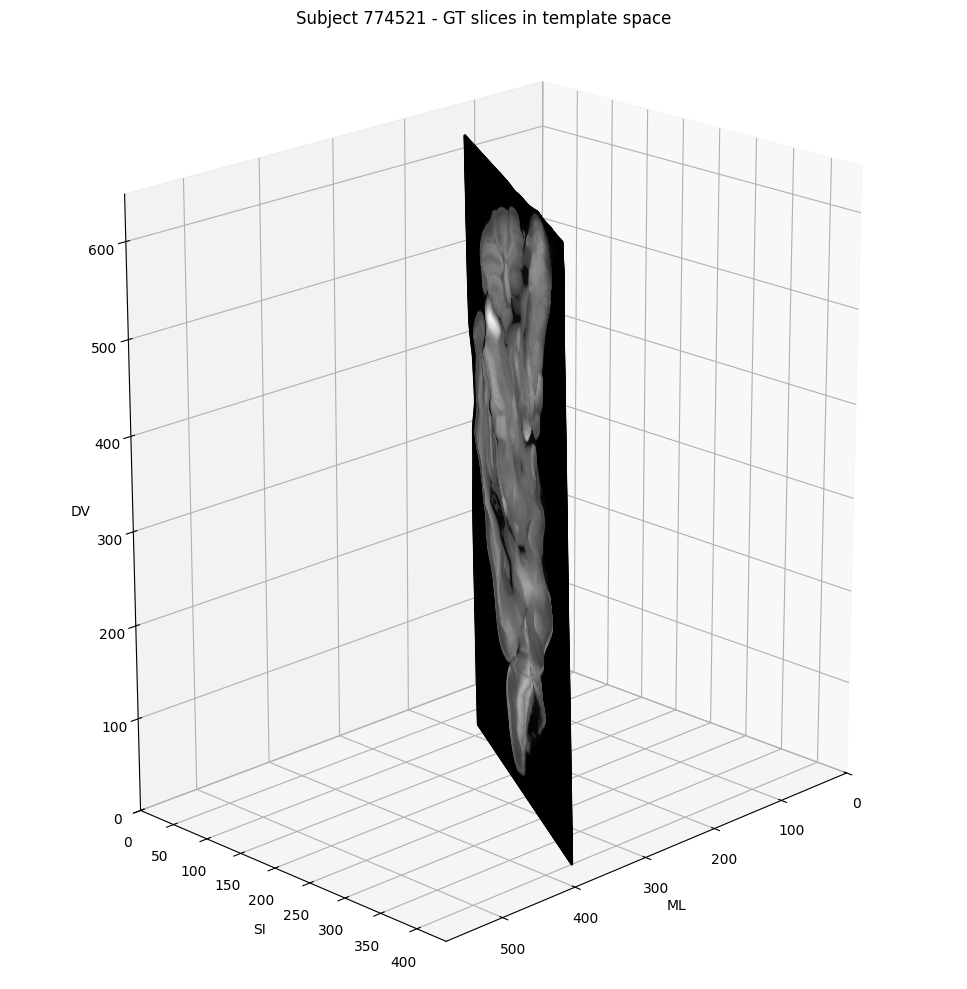

In [80]:
fig = visualize_subject_slices_3d(subject_id='774521', start_slice=534, num_slices=1)
plt.show()

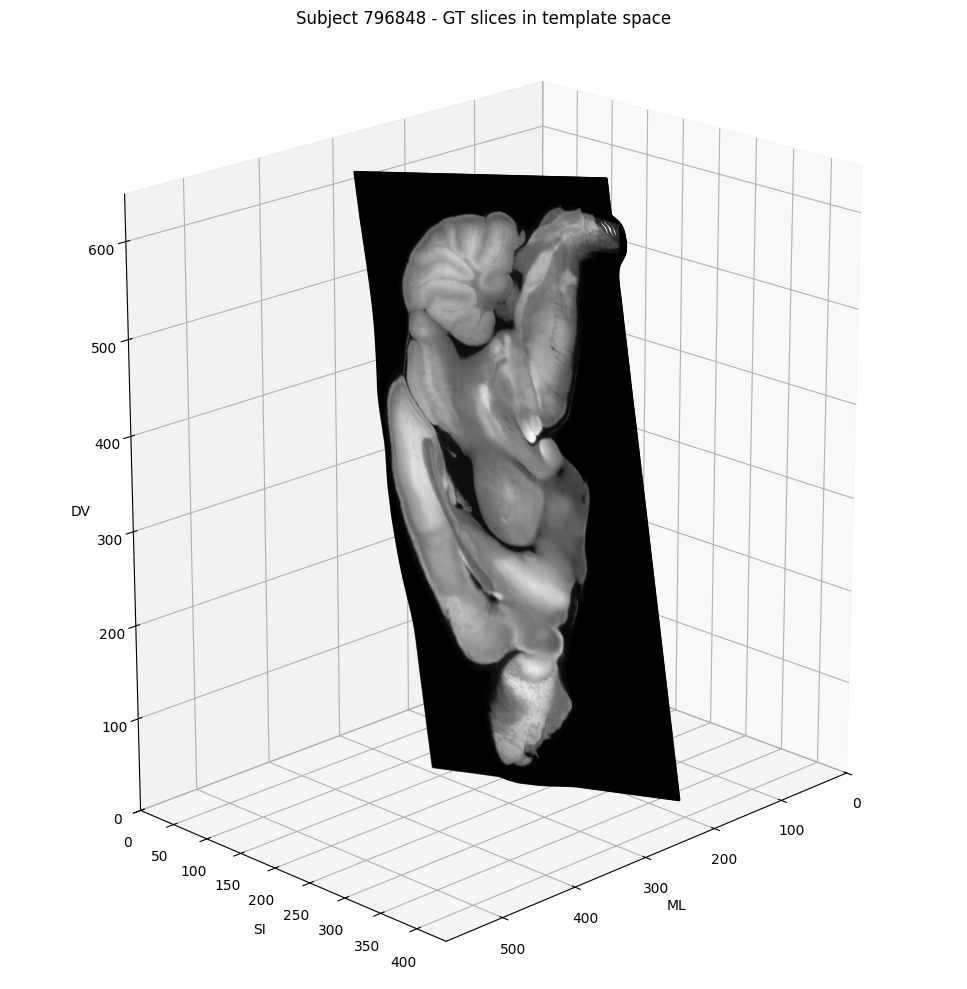

In [81]:
fig = visualize_subject_slices_3d(subject_id='796848', start_slice=473, num_slices=1)
plt.show()

# The input volume has different rotations!

so when we take a sagittal slice, it actually cuts through the volume differently and gets oriented differently in the template

![796848](img/796848_ng.png)

![774521_ng](img/774521_ng.png)


In [ ]:
from scipy.spatial.transform import Rotation
import numpy as np

def get_rotation_angles(affine_path: str) -> dict:
    """Extract rotation angles (in degrees) from an ANTs affine transform."""
    # Load the affine
    tx = ants.read_transform(affine_path)
    params = tx.parameters

    # For a 3D affine, first 9 params are the 3x3 matrix (row-major)
    matrix = params[:9].reshape(3, 3)

    # Extract rotation using polar decomposition
    # matrix = R @ S where R is rotation, S is scale/shear
    u, s, vh = np.linalg.svd(matrix)
    rotation_matrix = u @ vh

    # Handle reflection if det < 0
    if np.linalg.det(rotation_matrix) < 0:
        u[:, -1] *= -1
        rotation_matrix = u @ vh

    # Convert to Euler angles
    r = Rotation.from_matrix(rotation_matrix)
    angles = r.as_euler('xyz', degrees=True)

    return {
        'roll (around AP)': angles[1],
        'pitch (around ML)': angles[0],
        'yaw (around DV)': angles[2]
    }

with open('/Users/adam.amster/smartspim-registration/subject_metadata.json') as f:
    subject_meta = json.load(f)
for subject in subject_meta:
    subject = SubjectMetadata(**subject)
    angles = get_rotation_angles(subject)